In [1]:
# Make the libraries directory serachable for Python
import sys
sys.path.insert(1, './libraries')

In [2]:
from sklearn import preprocessing

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


In [3]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise

    final_series = series[..., np.newaxis].astype(np.float32)
    final_series = final_series.astype(np.float32)
    return final_series

In [4]:
# np.random.seed(42)

# n_steps = 50
# series = generate_time_series(10000, n_steps + 1)
# X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
# X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
# X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

In [5]:
# https://www.geeksforgeeks.org/numpy-ndarray/

# print("Array is of type: (series): ", type(series))
# print("No. of dimensions: (series): ", series.ndim)
# print("Shape of array: (series): ", series.shape)
# print("Size of array: (series): ", series.size)
# print("Array stores elements of type: (series): ", series.dtype)


In [6]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

In [7]:
# Early version of chords GUI interface
from chords_gui import chords_gui 

# Render the data download widget
domain = 'tzvolcano.chordsrt.com'
chords = chords_gui(domain)

# Define the initial start and end date for the date selector
start_date_string = '2021-01-01'
end_date_string = '2021-01-05'

# Generate the uer interface
chords.start_end_widgets(start_date_string, end_date_string)

Output()

In [8]:
chords.select_data_file()

Available Data Files


Output()

In [9]:
# Get the selected file to use
file_name = chords.available_data_files.value
print(file_name)

original_data = chords.load_data_from_file(file_name)

tzvolcano_chordsrt_com_instrument_id_1_2021-01-01_to_2021-01-01.csv
csv_files/tzvolcano_chordsrt_com_instrument_id_1_2021-01-01_to_2021-01-01.csv


In [10]:
# Calculate the seconds_since_epoch variable
# original_data["seconds_since_epoch"] = original_data['Time'].astype(np.int64)

# Show all the keys (variable names) in the loaded data set
# original_data.keys()

In [11]:
# Remove the "Time" variable from the data set, as it is not useful for the model
height_data = original_data.drop(["Time", "Longitude", "Latitude"], axis=1)

# Print out the remaing variable names, just to see we did remove "Time"
print(height_data.keys())
print(type(height_data))

Index(['Height'], dtype='object')
<class 'pandas.core.frame.DataFrame'>


In [12]:
# def generate_time_series(batch_size, n_steps):
#     freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
#     time = np.linspace(0, 1, n_steps)
#     series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
#     series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
#     series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
#     return series[..., np.newaxis].astype(np.float32)

In [13]:
n_steps = 5000

height = height_data['Height'].to_numpy()

# Rescale everything to the range between -1 and 1
height = np.interp(height, (height.min(), height.max()), (-1, +1))
height = height[:n_steps+1]

# height_series = height[..., np.newaxis].astype(np.float32)
height_series = np.array([height])
height_series = height_series[..., np.newaxis].astype(np.float32)

X_train = np.array(height_series[:,:-1])
y_train = np.array(height_series[:,-1])
# print(type(height))
# print(y_train)


print("Array is of type: (height_series): ", type(height_series))
print("No. of dimensions: (height_series): ", height_series.ndim)
print("Shape of array: (height_series): ", height_series.shape)
print("Size of array: (height_series): ", height_series.size)
print("Array stores elements of type: (height_series): ", height_series.dtype)
print("")
print("Array is of type: (X_train): ", type(X_train))
print("No. of dimensions: (X_train): ", X_train.ndim)
print("Shape of array: (X_train): ", X_train.shape)
print("Size of array: (X_train): ", X_train.size)
print("Array stores elements of type: (X_train): ", X_train.dtype)
print("")
print("Array is of type: (y_train): ", type(y_train))
print("No. of dimensions: (y_train): ", y_train.ndim)
print("Shape of array: (y_train): ", y_train.shape)
print("Size of array: (y_train): ", y_train.size)
print("Array stores elements of type: (y_train): ", y_train.dtype)
print("")

Array is of type: (height_series):  <class 'numpy.ndarray'>
No. of dimensions: (height_series):  3
Shape of array: (height_series):  (1, 5001, 1)
Size of array: (height_series):  5001
Array stores elements of type: (height_series):  float32

Array is of type: (X_train):  <class 'numpy.ndarray'>
No. of dimensions: (X_train):  3
Shape of array: (X_train):  (1, 5000, 1)
Size of array: (X_train):  5000
Array stores elements of type: (X_train):  float32

Array is of type: (y_train):  <class 'numpy.ndarray'>
No. of dimensions: (y_train):  2
Shape of array: (y_train):  (1, 1)
Size of array: (y_train):  1
Array stores elements of type: (y_train):  float32



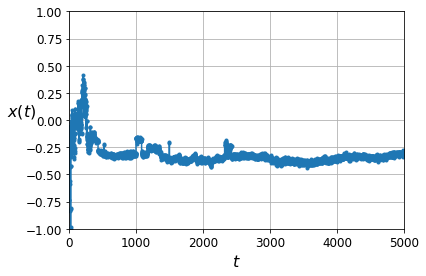

In [14]:
# print(X_train)
plot_series(X_train[0, :, 0])

In [15]:
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")

# history = model.fit(X_train, y_train, epochs=20,
#                     validation_data=(X_valid, y_valid))

history = model.fit(X_train, y_train, epochs=20,)

Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 0.7470
Epoch 2/20
1/1 [==============================] - 2s 2s/step - loss: 0.4774
Epoch 3/20
1/1 [==============================] - 2s 2s/step - loss: 0.2409
Epoch 4/20
1/1 [==============================] - 2s 2s/step - loss: 0.0440
Epoch 5/20
1/1 [==============================] - 2s 2s/step - loss: 0.0480
Epoch 6/20
1/1 [==============================] - 2s 2s/step - loss: 0.1149
Epoch 7/20
1/1 [==============================] - 2s 2s/step - loss: 0.1304
Epoch 8/20
1/1 [==============================] - 2s 2s/step - loss: 0.1122
Epoch 9/20
1/1 [==============================] - 2s 2s/step - loss: 0.0745
Epoch 10/20
1/1 [==============================] - 2s 2s/step - loss: 0.0340
Epoch 11/20
1/1 [==============================] - 2s 2s/step - loss: 0.0083
Epoch 12/20
1/1 [==============================] - 2s 2s/step - loss: 2.0962e-04
Epoch 13/20
1/1 [==============================] - 2s 2s/step - loss: 0.0016
Epoc

In [16]:
# np.random.seed(43) # not 42, as it would give the first series in the train set

# series = generate_time_series(1, n_steps + 10)
# X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
# X = X_new
# for step_ahead in range(10):
#     y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
#     X = np.concatenate([X, y_pred_one], axis=1)

# Y_pred = X[:, n_steps:]

In [17]:
n_steps = 500

height = height_data['Height'].to_numpy()
height = np.interp(height, (height.min(), height.max()), (-1, +1))
height = height[:n_steps+10]

# height_series = height[..., np.newaxis].astype(np.float32)
height_series = np.array([height])
height_series = height_series[..., np.newaxis].astype(np.float32)

# series = generate_time_series(1, n_steps + 10)

X_new = height_series[:, :n_steps]
Y_new = height_series[:, n_steps:]

X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
#     print(y_pred_one)
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [18]:
print(X_new.shape)
print(Y_new.shape)
print(Y_pred.shape)

(1, 500, 1)
(1, 10, 1)
(1, 10, 1)


Saving figure forecast_ahead_plot


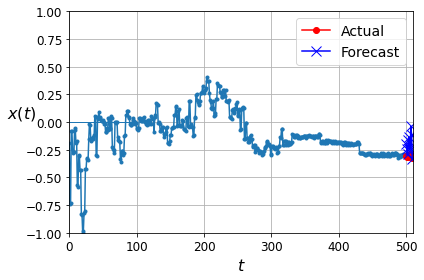

In [19]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
save_fig("forecast_ahead_plot")
plt.show()

In [20]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [21]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [22]:
Y_pred.shape

(2000, 10)

In [23]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.25022808

In [24]:

Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.22278848

In [25]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 0s 1ms/step - loss: 0.2186 - val_loss: 0.0606
Epoch 2/20
219/219 [==============================] - 0s 785us/step - loss: 0.0535 - val_loss: 0.0425
Epoch 3/20
219/219 [==============================] - 0s 788us/step - loss: 0.0406 - val_loss: 0.0353
Epoch 4/20
219/219 [==============================] - 0s 776us/step - loss: 0.0343 - val_loss: 0.0311
Epoch 5/20
219/219 [==============================] - 0s 787us/step - loss: 0.0300 - val_loss: 0.0283
Epoch 6/20
219/219 [==============================] - 0s 787us/step - loss: 0.0278 - val_loss: 0.0264
Epoch 7/20
219/219 [==============================] - 0s 800us/step - loss: 0.0262 - val_loss: 0.0249
Epoch 8/20
219/219 [==============================] - 0s 772us/step - loss: 0.0246 - val_loss: 0.0237
Epoch 9/20
219/219 [==============================] - 0s 751us/step - loss: 0.0236 - val_loss: 0.0229
Epoch 10/20
219/219 [==============================] - 0s 731us/step - loss: 0.0228 

In [26]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 4s 15ms/step - loss: 0.1216 - val_loss: 0.0317
Epoch 2/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0294 - val_loss: 0.0200
Epoch 3/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0198 - val_loss: 0.0160
Epoch 4/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0162 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0144 - val_loss: 0.0118
Epoch 6/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0127 - val_loss: 0.0112
Epoch 7/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0119 - val_loss: 0.0110
Epoch 8/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0114 - val_loss: 0.0103
Epoch 9/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0110 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0118 - val_lo

In [27]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

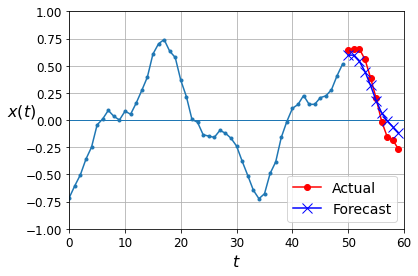

In [28]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [29]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [30]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(lr=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

/usr/local/lib/python3.9/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmp_1uae74r.py, line 12)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmp_1uae74r.py, line 12)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
219/219 [==============================] - 5s 17ms/step - loss: 0.0705 - last_time_step_mse: 0.0621 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0413 - last_time_step_mse: 0.0301 - val_loss: 0.0366 - val_last_time_step_mse: 0.0264
Epoch 3/20
219/219 [==============================] - 4s 17ms/step - l

In [ ]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

In [ ]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()